In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms, models # add models to the list
from torchvision.utils import make_grid
import os

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os
from PIL import Image
from IPython.display import display

# Filter harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Wczytanie pliku .csv
Zaczynamy od wczytania pliku csv w którym są zapisane ścieżki do poszczególnych zdjęć oraz współrzędne punktów

In [2]:
df = pd.read_csv('./files/data.csv') 
df_INPUT_DEPTH = df[['depth_img_I', 'depth_img_II']]
df_INPUT_RGB = df[['rgb_img_I', 'rgb_img_II']]
df_OUTPUT = df[['x1','y1','z1','x2','y2','z2']]

# Funkcje
Stworzenie fukncji, które tłumaczą pliki na język matematyczny

In [3]:
def load_rgb_dataset(top_dir='./files/images/rgb_img_I'):
    images_dataset = []
    for root, dirs, files in os.walk(top_dir):
        for name in files:
            # print(os.path.join(root, name))
            img = np.array(Image.open(os.path.join(root, name)))
            np.array(images_dataset.append(img))
    return np.array(images_dataset)

def load_depth_dataset(depth_series, row=0):    
    depth_dataset = []
    for n in range(depth_series.shape[0]):
        depth = np.array(np.load(depth_series.iloc[n,row]))
        np.array(depth_dataset.append(depth))
    
    return np.array(depth_dataset)

# Załadowanie danych
Ładujemy dane do zmiennych a następnie odpowiednio przekształcamy

In [4]:
RGBimg_begin = load_rgb_dataset('./files/images/rgb_img_I')
RGBimg_end = load_rgb_dataset('./files/images/rgb_img_II')

In [5]:
DEPTHimg_begin = load_depth_dataset(df_INPUT_DEPTH,0)
DEPTHimg_end = load_depth_dataset(df_INPUT_DEPTH,1)
# print(DEPTHimg_end[30][400])

In [6]:
# Creating input for model
transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Taking first rgb image
rgb_in = RGBimg_begin    
rgb_in = rgb_in.transpose(0,3,1,2)
rgb_in = torch.FloatTensor(rgb_in).div(255)
rgb_in = transform(rgb_in)

# Taking depth beginning state of the movement
depthBeg_in = DEPTHimg_begin
depthBeg_in = depthBeg_in.reshape((depthBeg_in.shape[0], depthBeg_in.shape[1], depthBeg_in.shape[2], 1))
depthBeg_in = depthBeg_in.transpose(0,3,1,2)
depthBeg_in = torch.FloatTensor(depthBeg_in).div(65535)

# Taking depth end state of the movement
depthEnd_in = DEPTHimg_end
depthEnd_in = depthEnd_in.reshape((depthEnd_in.shape[0], depthEnd_in.shape[1], depthEnd_in.shape[2], 1))
depthEnd_in = depthEnd_in.transpose(0,3,1,2)
depthEnd_in = torch.Tensor(depthEnd_in).div(65535)

# Taking depth difference between movements
depthDiff_in = abs(DEPTHimg_begin - DEPTHimg_end)
depthDiff_in = depthDiff_in.reshape((depthDiff_in.shape[0], depthDiff_in.shape[1], depthDiff_in.shape[2], 1))
depthDiff_in = depthDiff_in.transpose(0,3,1,2)
depthDiff_in = torch.Tensor(depthDiff_in).div(65535)

# Taking outputs
axis_out = df_OUTPUT.values
axis_out = torch.Tensor(axis_out)

# Koncowe wejście do modelu
DDD_in = torch.cat((depthBeg_in, depthEnd_in, depthDiff_in),axis=1)
DDD_in = transform(DDD_in)
print(DDD_in.shape)

RGBD_input = torch.cat((rgb_in, DDD_in),axis=1)
# RGBD_input = DDD_in

torch.Size([149, 3, 480, 640])


In [7]:
RGBD_input.shape

torch.Size([149, 6, 480, 640])

# RGB + D 
Na wejście do modelu zostanie podany tensor zawieający kombinację RGB + D 

In [8]:
# rgb_inTensor = torch.tensor(rgb_in.astype(float), dtype=torch.float)
# depth_inTensor = torch.tensor(depth_in.astype(float), dtype=torch.float)
# axis_outTensor = torch.tensor(axis_out.astype(float), dtype=torch.float)
X_train, X_test, y_train, y_test = train_test_split(RGBD_input, axis_out, test_size=0.2)

In [9]:
# X_train = X_train.cuda()
# X_test = X_test.cuda()
# y_train = y_train.cuda()
# y_test = y_test.cuda()

In [10]:
AoRD_trainDataset = TensorDataset(X_train, y_train)
AoRD_trainDataset = TensorDataset(X_test, y_test)

In [11]:
train_loader = DataLoader(AoRD_trainDataset, batch_size=8, shuffle=True)
test_loader = DataLoader(AoRD_trainDataset, batch_size=8, shuffle=True)

In [12]:
# plt.imshow(depth_in[34])

In [13]:
# plt.imshow(rgb_in[34])

In [14]:
# ResNetModel = models.resnet101(pretrained=False)
# ResNetModel

In [15]:
# ResNetModel.conv1 = nn.Conv2d(in_channels=4, out_channels=64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# Wyciąganie pojedyńczego elementu z batcha
Można zrobić to na kilka sposobów, ale ten jest najszybszy

In [16]:
for b, (X_train, y_train) in enumerate(train_loader):
    pass

In [17]:
X_train.shape

torch.Size([6, 6, 480, 640])

# Stworzenie modelu
Nazwałem model AoRNet od angielsiego **A**xis **o**f **R**rotation oraz od nazwy modelu matki Res**Net**`u 

In [18]:
class AoRNet(nn.Module):
    def __init__(self,pretrained=False ,input_channels=6, output_size=6):
        super().__init__()
        self.resnet50 = models.resnet50(pretrained=pretrained)
        self.resnet50.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.resnet50.fc = nn.Linear(in_features=2048, out_features=output_size, bias=True)
    
    def forward(self, X):
        return self.resnet50(X)

In [19]:
Model = AoRNet().cuda()

In [20]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(Model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min')

In [21]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')
# count_parameters(My_Model)

In [22]:
epochs = 100

train_losses = []
test_losses = []

for i in range(epochs):
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        # Apply the model
        y_pred = Model(X_train.cuda())
        loss = criterion(y_pred, y_train.cuda())
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%1 == 0:
            print(f'epoch: {i+1:2}  batch: {b}  loss: {loss.item():10.8f}')
    
    train_losses.append(loss.cpu().detach().numpy())
    scheduler.step(loss)
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            # Apply the model
            y_val = Model(X_test.cuda())
    loss = criterion(y_val, y_test.cuda())
    test_losses.append(loss.cpu().detach().numpy())
#     test_correct.append(tst_corr)

epoch:  1  batch: 1  loss: 2.28012943
epoch:  1  batch: 2  loss: 2.30933261
epoch:  1  batch: 3  loss: 0.26234064
epoch:  1  batch: 4  loss: 0.43855420
epoch:  2  batch: 1  loss: 0.24291277
epoch:  2  batch: 2  loss: 0.06675425
epoch:  2  batch: 3  loss: 0.28166404
epoch:  2  batch: 4  loss: 0.07097908
epoch:  3  batch: 1  loss: 0.12232298
epoch:  3  batch: 2  loss: 0.16730392
epoch:  3  batch: 3  loss: 0.11016083
epoch:  3  batch: 4  loss: 0.06787626
epoch:  4  batch: 1  loss: 0.11063676
epoch:  4  batch: 2  loss: 0.04443929
epoch:  4  batch: 3  loss: 0.03561527
epoch:  4  batch: 4  loss: 0.06023783
epoch:  5  batch: 1  loss: 0.04449012
epoch:  5  batch: 2  loss: 0.08317773
epoch:  5  batch: 3  loss: 0.05097241
epoch:  5  batch: 4  loss: 0.04311935
epoch:  6  batch: 1  loss: 0.04305856
epoch:  6  batch: 2  loss: 0.05106083
epoch:  6  batch: 3  loss: 0.04642919
epoch:  6  batch: 4  loss: 0.02326172
epoch:  7  batch: 1  loss: 0.02222460
epoch:  7  batch: 2  loss: 0.02867869
epoch:  7  b

epoch: 55  batch: 1  loss: 0.00165912
epoch: 55  batch: 2  loss: 0.00187966
epoch: 55  batch: 3  loss: 0.00320377
epoch: 55  batch: 4  loss: 0.00229757
epoch: 56  batch: 1  loss: 0.00236661
epoch: 56  batch: 2  loss: 0.00194661
epoch: 56  batch: 3  loss: 0.00231464
epoch: 56  batch: 4  loss: 0.00233607
epoch: 57  batch: 1  loss: 0.00143554
epoch: 57  batch: 2  loss: 0.00094277
epoch: 57  batch: 3  loss: 0.00161178
epoch: 57  batch: 4  loss: 0.00132834
epoch: 58  batch: 1  loss: 0.00475737
epoch: 58  batch: 2  loss: 0.00152072
epoch: 58  batch: 3  loss: 0.00124423
epoch: 58  batch: 4  loss: 0.00263727
epoch: 59  batch: 1  loss: 0.00197322
epoch: 59  batch: 2  loss: 0.00197280
epoch: 59  batch: 3  loss: 0.00199588
epoch: 59  batch: 4  loss: 0.00160673
epoch: 60  batch: 1  loss: 0.00063304
epoch: 60  batch: 2  loss: 0.00126428
epoch: 60  batch: 3  loss: 0.00128885
epoch: 60  batch: 4  loss: 0.00248227
epoch: 61  batch: 1  loss: 0.00149921
epoch: 61  batch: 2  loss: 0.00109977
epoch: 61  b

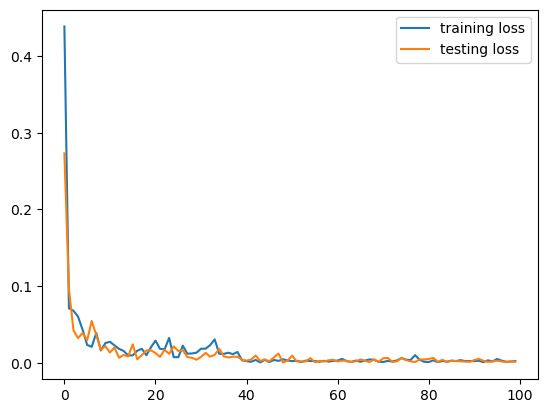

In [23]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='testing loss')
plt.legend();

In [24]:
torch.manual_seed(101)
with torch.no_grad():
    for b, (X_test, y_test) in enumerate(test_loader):
#         Apply the model
        y_val = Model(X_test.cuda())
#         print(y_val.shape)
        for j in range(y_val.shape[0]):
            print(f'--> BATCH: {b+1} <-- | --> ROW: {j} <--')
            print(f'----------------------------------------------------------------------------------------------')
            print(f'{"X1":>12} {"Y1":>12} {"Z1":>12} {"X2":>12} {"Y2":>12} {"Z2":>12}')
            print(f'{"PREDICTED:"}')
            print(f'[[{y_val[j][0]:12.5f}, {y_val[j][1]:12.5f}, {y_val[j][2]:12.5f}], [{y_val[j][3]:12.5f}, {y_val[j][4]:12.5f}, {y_val[j][5]:12.5f}]]')
            print(f'{"REAL:"}')
            print(f'[[{y_test[j][0]:12.5f}, {y_test[j][1]:12.5f}, {y_test[j][2]:12.5f}], [{y_test[j][3]:12.5f}, {y_test[j][4]:12.5f}, {y_test[j][5]:12.5f}]]')
            print(f'{"DIFFERENCE:"}')
            diff = np.abs(y_val.cpu().numpy()-y_test.cpu().numpy())
            print(f'[[{diff[j][0]:12.5f}, {diff[j][1]:12.5f}, {diff[j][2]:12.5f}], [{diff[j][3]:12.5f}, {diff[j][4]:12.5f}, {diff[j][5]:12.5f}]]')
            print(f'----------------------------------------------------------------------------------------------')
loss = criterion(y_val, y_test.cuda())
# diff = np.abs(y_val.cpu().numpy()-y_test.cpu().numpy())
print(f'RMSE: {loss:.8f}')

--> BATCH: 1 <-- | --> ROW: 0 <--
----------------------------------------------------------------------------------------------
          X1           Y1           Z1           X2           Y2           Z2
PREDICTED:
[[    -0.01801,      0.64195,     -2.05990], [    -0.02660,     -0.87560,     -2.19280]]
REAL:
[[    -0.02027,      0.64620,     -2.12700], [    -0.03380,     -0.92668,     -2.21650]]
DIFFERENCE:
[[     0.00226,      0.00426,      0.06711], [     0.00719,      0.05108,      0.02370]]
----------------------------------------------------------------------------------------------
--> BATCH: 1 <-- | --> ROW: 1 <--
----------------------------------------------------------------------------------------------
          X1           Y1           Z1           X2           Y2           Z2
PREDICTED:
[[    -0.01357,      0.64336,     -2.09214], [    -0.01341,     -0.90831,     -2.19223]]
REAL:
[[    -0.02027,      0.64620,     -2.12700], [    -0.03380,     -0.92668,     -2.21650]]


[[    -0.05311,      0.50977,     -1.49543], [    -0.01631,     -0.62991,     -1.55345]]
REAL:
[[    -0.03914,      0.54791,     -1.41700], [    -0.02323,     -0.63012,     -1.52450]]
DIFFERENCE:
[[     0.01397,      0.03814,      0.07843], [     0.00692,      0.00021,      0.02895]]
----------------------------------------------------------------------------------------------
--> BATCH: 4 <-- | --> ROW: 1 <--
----------------------------------------------------------------------------------------------
          X1           Y1           Z1           X2           Y2           Z2
PREDICTED:
[[    -0.31921,      0.62732,     -1.75007], [    -0.28684,     -0.70444,     -1.69418]]
REAL:
[[    -0.39655,      0.66889,     -1.73400], [    -0.34362,     -0.69997,     -1.67800]]
DIFFERENCE:
[[     0.07734,      0.04157,      0.01607], [     0.05678,      0.00447,      0.01618]]
----------------------------------------------------------------------------------------------
--> BATCH: 4 <-- | -->

In [25]:
print(f'{"PREDICTED":>12} {"ACTUAL":>8} {"DIFF":>8}')
        diff = np.abs(y_val[i].item()-y_test[i][k].item())
            print(diff)
#     print(f'{i+1:2}. {y_val[i].item():8.4f} {y_test[i].item():8.4f} {diff:8.4f}')

IndentationError: unexpected indent (2645487774.py, line 2)